In [1]:
import Pkg;
Pkg.add("DifferentialEquations")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [1]:
using DifferentialEquations, Plots
Threads.nthreads()

8

In [3]:
# ラプラシアンの計算（3次元）
function laplacian3D(ϕ, dx)
    return (circshift(ϕ, (1,0,0)) + circshift(ϕ, (-1,0,0)) +
            circshift(ϕ, (0,1,0)) + circshift(ϕ, (0,-1,0)) +
            circshift(ϕ, (0,0,1)) + circshift(ϕ, (0,0,-1)) - 6ϕ) / dx^2
end;

# equation of motion
function EoM!(du, u, p, t)
    dx = p[1]
    du[1,:,:,:] = u[2,:,:,:]
    du[2,:,:,:] = laplacian3D(u[1,:,:,:],dx) .- m² .* u[1,:,:,:]
end;

In [5]:
# シミュレーションのパラメータ
Nl = 2^6;  # 格子点数
L = 10.0;  # 系のサイズ
dx = L / Nl;  # 格子間隔
dt = 0.01;  # 時間ステップ
m² = 1.0;  # 質量パラメータ
tf = 10;
Nl

64

In [7]:
# 初期条件
phii = [exp(- ((i-Nl/2)^2 + (j-Nl/2)^2 + (k-Nl/2)^2)/(2*(Nl/10)^2)) for i=1:Nl, j=1:Nl, k=1:Nl];
pii = zeros(Nl, Nl, Nl);  # 共役運動量（速度）
field = stack([phii, pii], dims=1);

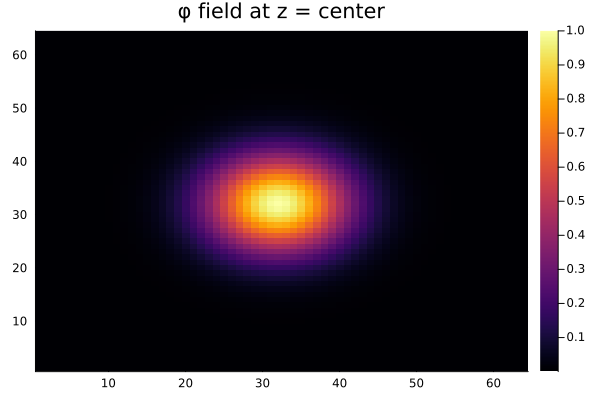

In [9]:
# 初期条件の可視化（中央断面の 2D ヒートマップ）
Plots.heatmap(field[1,:, :, div(Nl,2)], title="φ field at z = center")

In [11]:
tspan = (0,tf);
prob = ODEProblem(EoM!, field, tspan, (dx));

In [13]:
@time sol = solve(prob, RK4(), dt = dt);

  6.508771 seconds (12.31 M allocations: 14.607 GiB, 21.00% gc time, 50.39% compilation time)


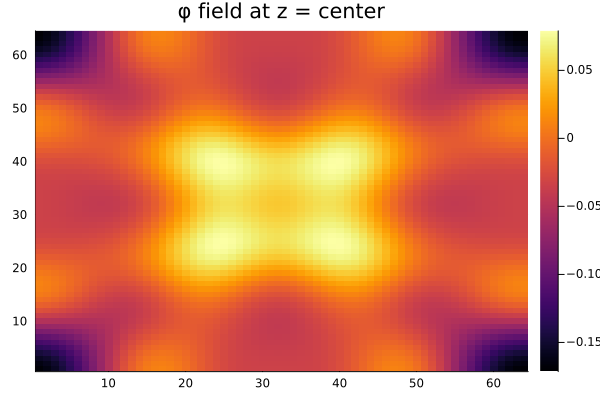

In [15]:
Plots.heatmap(sol.u[end][1, :, :, div(Nl,2)], title="φ field at z = center")